In [1]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import time
from math import exp
from tqdm import tqdm

from neuralnet.mlp import MLP, AntisymmetricMLP
#from neuralnet.resnet import ResNet, PowerSkipResNet

from rbm.rbm import RBM
from rbm.adjacency import get_adjacency_matrices
from rbm.coupling import get_coupling_matrix
from rbm.configurations import get_configurations
from rbm.loss import contrastive_divergence, kl_divergence

from utils.newton import find_root
from utils.samplers import HMC
from utils.grad import batch_grad, grad, jacobian
from utils import plots

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cpu')

# Models

In [3]:
lattice = 'lieb2'
representation = 'a1'

lieb_square, lieb_cross = get_adjacency_matrices(lattice)
coupling_matrix = get_coupling_matrix(representation)

n_couplers = coupling_matrix.size(0)

In [4]:
flow = MLP(
    in_dim=n_couplers, 
    out_dim=n_couplers, 
    hidden_depth=n_couplers, 
    width=16 * n_couplers, 
    device=device
)

sum(p.numel() for p in flow.parameters() if p.requires_grad)

321

In [5]:
fine = RBM(lieb_square, coupling_matrix, device=device)
coarse = RBM(lieb_cross, coupling_matrix, device=device)

In [6]:
sampler = HMC(steps=1, device=device)

# Training

In [7]:
epoch = 0
epochs = 4096
anneal_at = 1024
n_models = 16 * (3 ** n_couplers)
n_cd_samples = 512
k_fine = 16
k_coarse = 1

In [8]:
optimizer = torch.optim.Adam(flow.parameters())

Js = []
losses = []
roots = []
times = []

J = torch.randn(n_models, n_couplers, device=device)

In [9]:
beta = lambda epoch : 32/(1 + exp( -16 * (epoch - anneal_at) / epochs ))

In [11]:
flow.train()
for epoch in tqdm(range(epoch, epoch + epochs)):

    start = time.time()
    
    optimizer.zero_grad()

    sampler.potential = lambda _J : beta(epoch) * (flow(_J) ** 2).sum(dim=-1)
    #sampler.potential = lambda _J: beta(epoch) * (grad(monotone)(_J, True) ** 2).sum(dim=-1)

    # RG Flow
    J = sampler.step(J).detach()

    fine.J = J
    coarse.J = J + flow(J) #grad(monotone)(J, True)

    # Loss
    loss = contrastive_divergence(
        fine, coarse, 
        batch_size=n_cd_samples, 
        k_fine=k_fine, 
        k_coarse=k_coarse
    )
    loss.backward()
    optimizer.step()

    Js.append(J.cpu().detach())
    losses.append(float(loss))

    if epoch >= 2048:
        times.append(time.time() - start)
        if n_couplers == 1:
            x = torch.tensor([0.8], device=device)
        elif n_couplers == 5:
            x = torch.tensor([0.8, 0., 0., 0.8, 0.8], device=device)

        root = find_root(flow, x)
        #root = find_root(grad(lambda _x : monotone(_x).squeeze()), x)
        if torch.all(torch.logical_and(root > -4, root < 4)): 
            roots.append(root.cpu().detach())
        else:
            roots.append(torch.empty_like(root).fill_(float('nan')).cpu())

100%|███████████████████████████████████████| 4096/4096 [07:59<00:00,  8.54it/s]


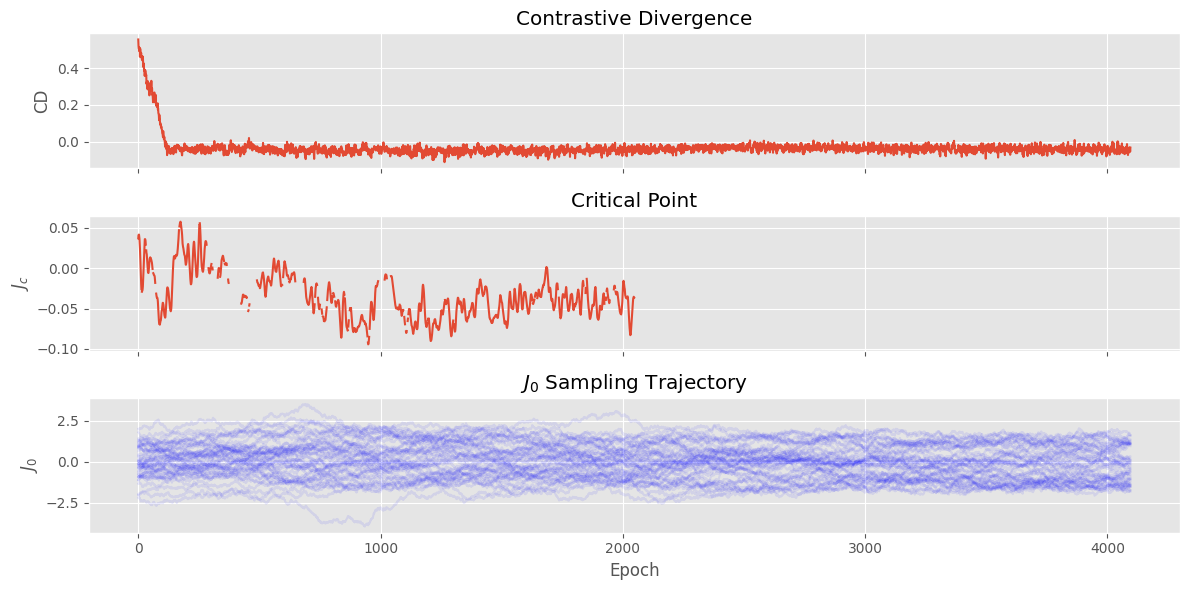

In [12]:
fig, axs = plt.subplots(n_couplers + 2, 1, figsize=(12, n_couplers * 2 + 4), sharex=True)

axs[0].plot(losses)
axs[0].set_ylabel('CD')
axs[0].set_title('Contrastive Divergence')

if len(roots) != 0:
    roots_tensor = torch.stack(roots)
    axs[1].plot(roots_tensor[:, 0])
    axs[1].set_ylabel(r'$J_c$')
    axs[1].set_title('Critical Point')

for traj in torch.stack(Js, dim=2):
    for i in range(2, n_couplers+2):
        axs[i].plot(traj[i-2].cpu().detach(), alpha=4/n_models, c='blue')
        axs[i].set_ylabel(rf'$J_{i-2}$')
        axs[i].set_title(rf'$J_{i-2}$ Sampling Trajectory')

axs[-1].set_xlabel('Epoch')

plt.tight_layout()

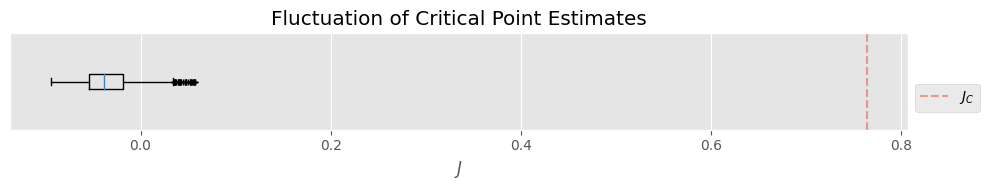

In [13]:
data = {
    '': roots_tensor[~torch.any(roots_tensor.isnan(),dim=1)][:, 0], 
    #'Flow': torch.load('data/a1-silu-flow-times.pt').squeeze(), 
    #'Monotone': torch.load('data/a1-silu-monotone-times.pt').squeeze()
}

fig, ax = plots.boxplots(data.values(), data.keys())

ax.set_title('Fluctuation of Critical Point Estimates')
ax.set_xlabel(r'$J$')

fig.tight_layout()

#fig.savefig('figures/a1-silu-flow-monotone-estimates.png')

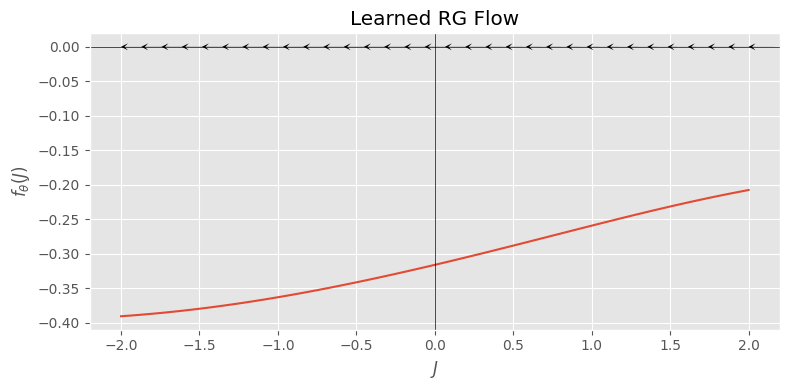

In [10]:
flow.eval()

if n_couplers == 1:
    xlim = (-2, 2)
    
    fig, ax = plots.plot1d(flow, xlim=xlim, device=device)
    
    ax.set_ylabel(r'$f_{\theta}(J)$')
    ax.set_xlabel(r'$J$')
    ax.set_title(r'Learned RG Flow')
    

    x = torch.linspace(*xlim, 32, device=device).unsqueeze(1)
    fx = flow(x).cpu().detach()
    x = x.cpu()
    ax.quiver(x, torch.zeros_like(x), fx, torch.zeros_like(fx), pivot='tip', width=0.0001, headwidth=100, headlength=100, headaxislength=50, color='black')

else:
    fig, axs = plots.nd_flows(
        flow, 
        lambda grid: -torch.log(sampler.potential(grid)), 
        n_couplers, 
        xlim=(-1.5, 1.5), 
        ylim=(-1.5, 1.5), 
        res=128
    )

    fig.suptitle(r'Flows and $- \log || f_{\theta} ||$ on the Coordinate Planes', size=24)

fig.tight_layout()